<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/unluckid/model/blob/main/tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 설정

In [1]:
!pip install --upgrade tensorflow
!pip install --upgrade keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.3/381.3 kB 24.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
    

In [2]:
import os
import xml.etree.ElementTree as ET
import tensorflow as tf
import keras_cv
import requests
import zipfile

from tqdm.auto import tqdm
from tensorflow import keras
from keras_cv import bounding_box
from keras_cv import visualization

In [ ]:
import gdown
import numpy as np
import cv2
import numpy as np
import os
import shutil

file_id = '1e-ovYZtdJVMLnaK_469TWhSXSdHoLHQx'
download_url = f'https://drive.google.com/uc?id={file_id}'



gdown.download(download_url, '/content/dataset.zip', quiet=False)


In [ ]:
import zipfile


zip_file_path = '/content/dataset.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"압축이 {extract_path}에 해제되었습니다.")

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier,BaggingClassifier
from tensorflow.keras.applications import VGG16, Xception , InceptionV3
from tensorflow.keras.models import load_model, Model
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score

In [ ]:
train_dir = "datasets/train"
val_dir = "datasets/val"
# 데이터 증강 (학습 데이터에만 적용)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,       # 회전 범위 증가
)

# 검증 데이터는 증강하지 않음 (단순히 정규화만 적용)
val_datagen = ImageDataGenerator(rescale=1./255)

# 학습 데이터 생성기
train_generator = train_datagen.flow_from_directory(
    train_dir,  # 학습 데이터 경로
    target_size=(224, 224),  # VGG16의 입력 크기에 맞게 리사이즈
    batch_size=32,
    class_mode='categorical',  # 다중 클래스 분류
    shuffle=True
)

# 검증 데이터 생성기
val_generator = val_datagen.flow_from_directory(
    val_dir,  # 검증 데이터 경로
    target_size=(224, 224),  # VGG16의 입력 크기에 맞게 리사이즈
    batch_size=32,
    class_mode='categorical'  # 다중 클래스 분류
)

# tf.data.Dataset으로 변환
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 10), dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 10), dtype=tf.float32)
    )
)
train_dataset = train_dataset.repeat()  # 학습 데이터 무한 반복
val_dataset = val_dataset.repeat()      # 검증 데이터 무한 반복


In [ ]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 모델에 Flatten 레이어 추가
x = layers.Flatten()(vgg16_base.output)

# Dense 레이어 추가 (출력 클래스 수에 맞게)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.6)(x)  # Dropout 추가
x = layers.Dense(10, activation='softmax')(x)

# 새로운 모델 정의
model = models.Model(inputs=vgg16_base.input, outputs=x)

# VGG16의 base 일부 레이어를 학습 가능하게 만들기
for layer in vgg16_base.layers:
    layer.trainable = False
# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# steps_per_epoch, validation_steps 설정
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

In [ ]:
history = model.fit(
    train_dataset,  # tf.data.Dataset 사용
    steps_per_epoch=steps_per_epoch,  # 배치 크기에 맞춰 학습 스텝 설정
    epochs=20,  # 에포크 수
    validation_data=val_dataset,  # 검증 데이터
    validation_steps=validation_steps  # 검증 배치 크기 맞추기
)

# 모델 저장
model.save('vgg16.keras')

27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 400ms/step
y_true: 852, y_scores: 852


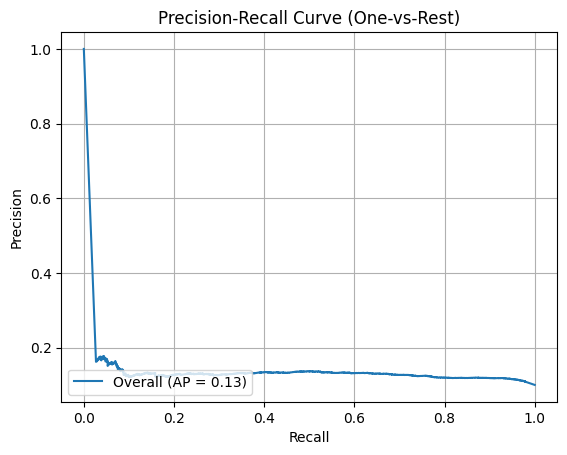

In [ ]:
y_true = val_generator.classes  # 실제 클래스 라벨

# 예측 확률 계산 (전체 검증 데이터에 대해 예측)
y_scores = model2.predict(val_generator)

# y_true와 y_scores의 길이 확인
print(f"y_true: {len(y_true)}, y_scores: {y_scores.shape[0]}")

# 각 클래스를 하나로 통합하여 One-vs-Rest 방식으로 precision-recall curve 계산
# 각 샘플에 대해 가장 높은 예측 확률을 갖는 클래스 선택
y_true_one_hot = np.zeros_like(y_scores)
y_true_one_hot[np.arange(len(y_true)), y_true] = 1  # 실제 클래스 라벨을 One-hot 형식으로 변환

# precision-recall curve 계산
precision, recall, _ = precision_recall_curve(y_true_one_hot.ravel(), y_scores.ravel())

# 평균 정밀도 (Average Precision) 계산
average_precision = average_precision_score(y_true_one_hot.ravel(), y_scores.ravel())

# Precision-Recall Curve 그리기
plt.plot(recall, precision, label=f'Overall (AP = {average_precision:.2f})')

# 그래프 설정
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [ ]:
 #모델 1의 정확도 계산
from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score
actual_labels =  train_generator.classes
model1_predictions = model1.predict(train_generator)
model1_final_predictions = np.argmax(model1_predictions, axis=1)
model1_accuracy = accuracy_score(actual_labels, model1_final_predictions)
print(f"Model 1 Accuracy: {model1_accuracy:.4f}")

# 모델 2의 정확도 계산
model2_predictions = model2.predict(train_generator)
model2_final_predictions = np.argmax(model2_predictions, axis=1)
model2_accuracy = accuracy_score(actual_labels, model2_final_predictions)
print(f"Model 2 Accuracy: {model2_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


153/153 ━━━━━━━━━━━━━━━━━━━━ 63s 409ms/step
Model 1 Accuracy: 0.2250
118/153 ━━━━━━━━━━━━━━━━━━━━ 14s 413ms/step